In [1]:
import jax
from jax.flatten_util import ravel_pytree
import jax.numpy as jnp

import optax
import jaxopt

import matplotlib.pyplot as plt

from gpax import ExactGP, SparseGP, GibbsKernel, HomoscedasticNoise, HeteroscedasticNoise
from gpax.utils import constrain, unconstrain, randomize, train_fn
from gpax.plotting import plot_posterior

import tensorflow_probability.substrates.jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

from stheno import GP, EQ

import lab.jax as B
from matrix import Dense, dense

import regdata as rd

import pprint
pp = pprint.PrettyPrinter(depth=4)

# from jax.config import config
# config.update("jax_debug_nans", True)

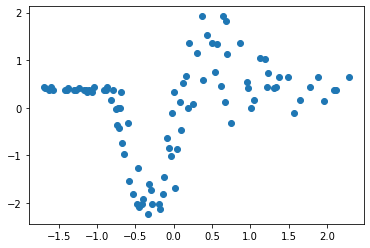

In [2]:
# X = jnp.linspace(-1, 1, 100).reshape(-1, 1)
# # X = jnp.concatenate([X[:40], X[60:]])
# key = jax.random.PRNGKey(0)
# y = jnp.sin(2 * jnp.pi * X) + jax.random.normal(key, X.shape)*0.2

X, y, X_test = rd.MotorcycleHelmet().get_data()

plt.scatter(X, y);

## Exact GP

In [11]:
X_inducing = X[::20]
print(X_inducing.shape)

kernel = GibbsKernel(X_inducing=X_inducing)
noise = HeteroscedasticNoise(use_kernel_inducing=True)
model = ExactGP(kernel=kernel, noise=noise)
prior = tfd.Normal(loc=0.0, scale=1.0)
def loss_fun(params):
#     print(params["kernel"]["latent_log_scale"])
#     print(prior.log_prob(params["kernel"]["latent_log_scale"]).sum())
    scale_prior = prior.log_prob(params["kernel"]["latent_log_scale"]).sum()
    var_prior = prior.log_prob(params["kernel"]["latent_log_variance"]).sum()
    noise_prior = prior.log_prob(params["noise"]["latent_log_noise"]).sum()
    return -model.log_probability(params, X, y) - scale_prior - var_prior - noise_prior

(5, 1)


In [12]:
key = jax.random.PRNGKey(0)
params = model.initialize_params(key, X, X_inducing)
bijectors = model.get_bijectors()

params = unconstrain(params, bijectors)
key = jax.random.PRNGKey(0)
params = randomize(params, key)
# ravel_pytree(jax.value_and_grad(lambda params: loss_fun(constrain(params, bijectors)))(params)[1])

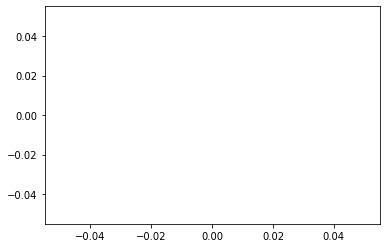

In [13]:
key = jax.random.PRNGKey(0)
params = model.initialize_params(key, X, X_inducing)
bijectors = model.get_bijectors()

params = unconstrain(params, bijectors)
key = jax.random.PRNGKey(105)
# x_ind = params["kernel"]["X_inducing"]
params = randomize(params, key)
# params["kernel"]["X_inducing"] = x_ind

# print(ravel_pytree(constrain(params, bijectors)))

optimizer = optax.adam(1e-2)
num_epochs = 200
result = train_fn(loss_fun, params, bijectors, optimizer, num_epochs=num_epochs)
plt.plot(result["loss_history"]);

# opt = jaxopt.ScipyMinimize(fun=lambda params: loss_fun(constrain(params, bijectors)), method="L-BFGS-B")
# res = opt.run(params)
# result = {'params': res.params}
# print(res.state.fun_val)

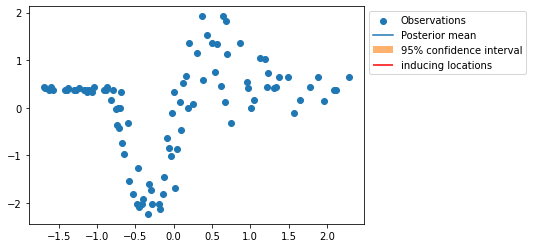

In [14]:
params = jax.tree_map(lambda x: x[35], result["params_history"])
# params = result["params"]
params = constrain(params, bijectors)
ax = plot_posterior(model, params, X, y, X_test, ax=None, alpha=0.6);
plt.vlines(params['kernel']['X_inducing'], *plt.ylim(), label='inducing locations', color='red')
ax.legend(bbox_to_anchor=(1,1));

## Sparse GP

In [7]:
model = SparseGP(
#     kernel=GibbsKernel(X_inducing=X_inducing),
    kernel=GibbsKernel(),
    noise=HeteroscedasticNoise(),
    method="vfe", # "vfe" or "fitc" or "dtc"
)

def loss_fun(params):
    return -model.elbo(params, X, y)

optimizer = optax.adam(1e-2)
num_epochs = 100

params = model.initialize_params(key, X, X_inducing)
bijectors = model.get_bijectors()

params = unconstrain(params, bijectors)
key = jax.random.PRNGKey(10)
x_ind, x_ind2 = params["X_inducing"], params["kernel"]["X_inducing"]
params = randomize(params, key)
params["X_inducing"], params["kernel"]["X_inducing"] = x_ind, x_ind2
result = train_fn(loss_fun, params, bijectors, optimizer, num_epochs=num_epochs)

plt.plot(result["loss_history"]);

NameError: name 'PseudoObs' is not defined

In [ ]:
params = jax.tree_map(lambda x: x[660], result["params_history"])
params = constrain(params, bijectors)
ax = plot_posterior(model, params, X, y, X_test, ax=None, alpha=0.6)
f = model.get_gp(params)
pseudo_obs = model.get_pseudo_obs(params, f, X, y)
ax.plot(params['X_inducing'], B.dense(pseudo_obs.mu(f.measure)), 'o', color='red', label='pseudo obs');
ax.legend(bbox_to_anchor=(1,1));

## Appendix

GibbsKernel(active_dims=None, ARD=True, X_inducing=array([[ 0.67000835],
       [ 0.12247464],
       [ 0.69882592],
       [ 0.16570099],
       [ 2.28379191],
       [ 0.03602195],
       [ 1.49130891],
       [ 2.09647775],
       [-0.67000835],
       [-1.27517719]]), flex_scale=True, flex_variance=True)